In [19]:
import numpy as np
import pandas as pd
from collections import Counter


def evaluate_topk_metrics(topk_df, ground_truth_df, train_df, k=10):
    """
    Evaluate Top-K recommendation metrics using RecBole-consistent implementation.

    Parameters:
    - topk_df: DataFrame with ['user_id', 'gender', 'topk_items']
    - ground_truth_df: DataFrame with ['user_id', 'relevant_items_sorted_by_rating']
    - train_df: DataFrame with ['user_id', 'artist_id:token', 'label:float'] for item popularity
    - k: Top-k cutoff

    Returns:
    - dict: evaluation results, printed and returned
    """

    # === Step 1: Clean and parse input ===
    topk_df['user_id'] = topk_df['user_id'].astype(str)
    topk_df['topk_items'] = topk_df['topk_items'].astype(str)
    topk_df['gender'] = topk_df['gender'].astype(str)
    ground_truth_df['user_id'] = ground_truth_df['user_id'].astype(str)
    ground_truth_df['relevant_items_sorted_by_rating'] = ground_truth_df['relevant_items_sorted_by_rating'].astype(str)

    user2gt = dict(zip(
        ground_truth_df['user_id'],
        ground_truth_df['relevant_items_sorted_by_rating'].apply(lambda x: set(x.split(',')))
    ))
    user2topk = dict(zip(
        topk_df['user_id'],
        topk_df['topk_items'].apply(lambda x: x.split(',')[:k])
    ))
    user2gender = dict(zip(topk_df['user_id'], topk_df['gender']))

    # Step 1: Count item popularity (interaction frequency)
    train_df['artist_id:token'] = train_df['artist_id:token'].astype(str)
    item_popularity = train_df['artist_id:token'].value_counts().to_dict()
    # Step 2: Sort items by popularity (descending)
    item_freq_sorted = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)
    # Step 3: Define long-tail cutoff (e.g., bottom 20%)
    tail_ratio = 0.2
    total_item_count = len(item_freq_sorted)
    cutoff_index = int((1 - tail_ratio) * total_item_count)
    tail_items = set(item for item, _ in item_freq_sorted[cutoff_index:])

    total_item_count = len(item_freq_sorted)

    precision_list, recall_list, hit_list, ndcg_list = [], [], [], []
    ndcg_male, ndcg_female = [], []
    map_list = []
    user_items_male, user_items_female = set(), set()
    recommended_items = []
    avg_pop_list = []
    tail_pct_list = []

    for user, pred in user2topk.items():
        if user not in user2gt:
            continue
        gt_items = user2gt[user]
        hits = [1 if item in gt_items else 0 for item in pred]
        hit_count = sum(hits)

        # Accuracy
        precision = hit_count / k
        recall = hit_count / len(gt_items) if gt_items else 0
        hit = 1.0 if hit_count > 0 else 0.0
        ap = 0
        num_hits = 0
        for i, item in enumerate(pred):
            if item in gt_items:
                num_hits += 1
                ap += num_hits / (i + 1)
        map_score = ap / min(len(gt_items), k) if gt_items else 0
        dcg = sum([rel / np.log2(i + 2) for i, rel in enumerate(hits)])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(gt_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        hit_list.append(hit)
        map_list.append(map_score)
        ndcg_list.append(ndcg)

        if user2gender[user] == 'M':
            ndcg_male.append(ndcg)
            user_items_male.update(pred)
        elif user2gender[user] == 'F':
            ndcg_female.append(ndcg)
            user_items_female.update(pred)

        # Diversity / Popularity
        recommended_items.extend(pred)
        avg_pop = np.mean([item_popularity.get(item, 0) for item in pred])
        avg_pop_list.append(avg_pop)

        tail_pct = np.mean([1 if item in tail_items else 0 for item in pred])
        tail_pct_list.append(tail_pct)

    # === Diversity Metrics ===
    rec_item_counts = Counter(recommended_items)  #item_id:token -> frequency
    rec_item_freqs = np.array(list(rec_item_counts.values()))
    total_recs = len(user2topk) * k
    p_i = rec_item_freqs / total_recs

    # Shannon Entropy (Normalized)
    if len(p_i) > 1:
        shannon = -np.sum(p_i * np.log(p_i)) / np.log(len(p_i))
    else:
        shannon = 0

    # Gini Index (RecBole version)
    all_item_ids = list(item_popularity.keys())
    rec_freq_all = np.array([rec_item_counts.get(item_id, 0) for item_id in all_item_ids])
    rec_freq_all_sorted = np.sort(rec_freq_all)
    n = len(rec_freq_all_sorted)
    idx = np.arange(1, n + 1)
    gini = np.sum((2 * idx - n - 1) * rec_freq_all_sorted) / (n * np.sum(rec_freq_all_sorted))

    ugf_ndcg = abs(np.mean(ndcg_male) - np.mean(ndcg_female))
    ugf_ic = abs(len(user_items_male) / total_item_count - len(user_items_female) / total_item_count)

    # === Final Output ===
    results = {
        f"Total users evaluated": len(ndcg_list),
        f"Precision@{k}": np.mean(precision_list),
        f"Recall@{k}": np.mean(recall_list),
        f"Hit@{k}": np.mean(hit_list),
        f"MAP@{k}": np.mean(map_list),
        f"NDCG@{k} (all)": np.mean(ndcg_list),
        f"NDCG@{k} (male)": np.mean(ndcg_male),
        f"NDCG@{k} (female)": np.mean(ndcg_female),
        f"NDCG@{k} (UGF)": ugf_ndcg,
        f"ItemCoverage@{k} (male)": len(user_items_male) / total_item_count,
        f"ItemCoverage@{k} (female)": len(user_items_female) / total_item_count,
        f"ItemCoverage@{k} (UGF)": ugf_ic,
        f"ItemCoverage@{k} (all)": len(rec_item_counts) / total_item_count,
        f"AveragePopularity@{k}": np.mean(avg_pop_list),
        f"ShannonEntropy@{k}": shannon,
        f"GiniIndex@{k}": gini,
        f"TailPercentage@{k}": np.mean(tail_pct_list)
    }
    # Print with 4 decimals
    for k, v in results.items():
        print(f"{k:<25}: {v:.4f}" if isinstance(v, float) else f"{k:<25}: {v}")
    return results

In [20]:
ground_truth = pd.read_csv('../rank_results/lastfm-nl/lastfm_test_ground_truth_sorted.csv')

In [21]:
topk_df_base = pd.read_csv('../rank_results/lastfm-nl/lastfm_top50.csv')
train_df_base = pd.read_csv('../datasets/split_datasets/lastfm-nl/lastfm-nl.train.inter', sep='\t')
base_result = evaluate_topk_metrics(topk_df_base, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0332
Recall@10                : 0.0753
Hit@10                   : 0.2902
MAP@10                   : 0.0270
NDCG@10 (all)            : 0.0594
NDCG@10 (male)           : 0.0601
NDCG@10 (female)         : 0.0565
NDCG@10 (UGF)            : 0.0036
ItemCoverage@10 (male)   : 0.1016
ItemCoverage@10 (female) : 0.0381
ItemCoverage@10 (UGF)    : 0.0635
ItemCoverage@10 (all)    : 0.1116
AveragePopularity@10     : 631.4422
ShannonEntropy@10        : 0.6938
GiniIndex@10             : 0.9888
TailPercentage@10        : 0.0040


In [22]:
topk_df_oversample = pd.read_csv('../rank_results/lastfm-nl/lastfm_top10_oversample.csv')
train_df_oversample = pd.read_csv('../oversample/datasets/lastfm-nl/lastfm-nl.train.inter', sep='\t')
oversample_result = evaluate_topk_metrics(topk_df_oversample, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0350
Recall@10                : 0.0797
Hit@10                   : 0.3049
MAP@10                   : 0.0275
NDCG@10 (all)            : 0.0614
NDCG@10 (male)           : 0.0613
NDCG@10 (female)         : 0.0618
NDCG@10 (UGF)            : 0.0005
ItemCoverage@10 (male)   : 0.1650
ItemCoverage@10 (female) : 0.0568
ItemCoverage@10 (UGF)    : 0.1082
ItemCoverage@10 (all)    : 0.1860
AveragePopularity@10     : 537.2037
ShannonEntropy@10        : 0.7136
GiniIndex@10             : 0.9780
TailPercentage@10        : 0.0112


In [23]:
topk_df_undersample = pd.read_csv('../rank_results/lastfm-nl/lastfm_top10_undersample.csv')
train_df_undersample = pd.read_csv('../undersample/datasets/lastfm-nl/lastfm-nl.train.inter', sep='\t')
undersample_presult = evaluate_topk_metrics(topk_df_undersample, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0347
Recall@10                : 0.0786
Hit@10                   : 0.2974
MAP@10                   : 0.0279
NDCG@10 (all)            : 0.0615
NDCG@10 (male)           : 0.0621
NDCG@10 (female)         : 0.0591
NDCG@10 (UGF)            : 0.0030
ItemCoverage@10 (male)   : 0.1674
ItemCoverage@10 (female) : 0.0577
ItemCoverage@10 (UGF)    : 0.1097
ItemCoverage@10 (all)    : 0.1895
AveragePopularity@10     : 553.2270
ShannonEntropy@10        : 0.7099
GiniIndex@10             : 0.9775
TailPercentage@10        : 0.0108


In [24]:
topk_df_relabel = pd.read_csv('../rank_results/lastfm-nl/lastfm_top10_relabel.csv')
train_df_relabel = pd.read_csv('../relabel/datasets/lastfm-nl/lastfm-nl.train.inter', sep='\t')
relabel_result = evaluate_topk_metrics(topk_df_relabel, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0345
Recall@10                : 0.0787
Hit@10                   : 0.2981
MAP@10                   : 0.0279
NDCG@10 (all)            : 0.0614
NDCG@10 (male)           : 0.0624
NDCG@10 (female)         : 0.0572
NDCG@10 (UGF)            : 0.0052
ItemCoverage@10 (male)   : 0.1404
ItemCoverage@10 (female) : 0.0490
ItemCoverage@10 (UGF)    : 0.0914
ItemCoverage@10 (all)    : 0.1575
AveragePopularity@10     : 599.8631
ShannonEntropy@10        : 0.6912
GiniIndex@10             : 0.9831
TailPercentage@10        : 0.0080


In [25]:
topk_df_fair = pd.read_csv('../rank_results/lastfm-nl/lastfm_top10_fair.csv')
fair_result = evaluate_topk_metrics(topk_df_fair, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0332
Recall@10                : 0.0753
Hit@10                   : 0.2902
MAP@10                   : 0.0270
NDCG@10 (all)            : 0.0594
NDCG@10 (male)           : 0.0601
NDCG@10 (female)         : 0.0565
NDCG@10 (UGF)            : 0.0036
ItemCoverage@10 (male)   : 0.1042
ItemCoverage@10 (female) : 0.0386
ItemCoverage@10 (UGF)    : 0.0656
ItemCoverage@10 (all)    : 0.1147
AveragePopularity@10     : 631.1572
ShannonEntropy@10        : 0.6922
GiniIndex@10             : 0.9886
TailPercentage@10        : 0.0040


In [26]:
topk_df_calibrated = pd.read_csv('../rank_results/lastfm-nl/lastfm_top10_calibrated.csv')
calibrated_result = evaluate_topk_metrics(topk_df_calibrated, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0312
Recall@10                : 0.0711
Hit@10                   : 0.2762
MAP@10                   : 0.0263
NDCG@10 (all)            : 0.0571
NDCG@10 (male)           : 0.0576
NDCG@10 (female)         : 0.0554
NDCG@10 (UGF)            : 0.0022
ItemCoverage@10 (male)   : 0.0920
ItemCoverage@10 (female) : 0.0379
ItemCoverage@10 (UGF)    : 0.0541
ItemCoverage@10 (all)    : 0.1011
AveragePopularity@10     : 590.1089
ShannonEntropy@10        : 0.7074
GiniIndex@10             : 0.9893
TailPercentage@10        : 0.0023


In [27]:
topk_df_equity = pd.read_csv('../rank_results/lastfm-nl/lastfm_top10_equity.csv')
equity_result = evaluate_topk_metrics(topk_df_equity, ground_truth, train_df_base, k=10)

Total users evaluated    : 8769
Precision@10             : 0.0323
Recall@10                : 0.0735
Hit@10                   : 0.2804
MAP@10                   : 0.0254
NDCG@10 (all)            : 0.0567
NDCG@10 (male)           : 0.0573
NDCG@10 (female)         : 0.0545
NDCG@10 (UGF)            : 0.0028
ItemCoverage@10 (male)   : 0.1951
ItemCoverage@10 (female) : 0.0714
ItemCoverage@10 (UGF)    : 0.1237
ItemCoverage@10 (all)    : 0.2159
AveragePopularity@10     : 487.5218
ShannonEntropy@10        : 0.7500
GiniIndex@10             : 0.9674
TailPercentage@10        : 0.0086


In [44]:
import pandas as pd

# === Step 1: Organize Results ===

results_dict = {
    "Baseline": base_result,
    "Relabel": relabel_result,
    "Oversample": oversample_result,
    "Undersample": undersample_presult,
    "FA*IR": fair_result,
    "Calibration": calibrated_result,
    "Equity": equity_result
}

# === Step 2: Rename Columns for Publication ===
column_rename_map = {
    "Precision@10": "Pre@10",
    "Recall@10": "Rec@10",
    "Hit@10": "Hit@10",
    "MAP@10": "MAP@10",
    "NDCG@10 (all)": "NDCG@10",
    "NDCG@10 (male)": "NDCG@10(M)",
    "NDCG@10 (female)": "NDCG@10(F)",
    "NDCG@10 (UGF)": "UGF-NDCG@10",
    "ItemCoverage@10 (male)": "IC@10(M)",
    "ItemCoverage@10 (female)": "IC@10(F)",
    "ItemCoverage@10 (UGF)": "UGF-IC@10",
    "ItemCoverage@10 (all)": "IC@10",
    "AveragePopularity@10": "AP@10",
    "ShannonEntropy@10": "SE@10",
    "GiniIndex@10": "GI@10",
    "TailPercentage@10": "TP@10"
}

# === Step 3: Build and Clean the DataFrame ===
df_results = pd.DataFrame(results_dict).T  # methods as rows
df_results = df_results.round(4)  # round all values to 4 decimals
df_results.drop(columns=["Total users evaluated"], errors='ignore', inplace=True)  # optional cleanup
df_results.rename(columns=column_rename_map, inplace=True)

# Add method name as a column for display/export
df_results.index.name = "Method"
df_results.reset_index(inplace=True)

df_results.to_csv("lastfm_nl_evaluation_results.csv", index=False)
print("Saved the metrics score to lastfm_nl_evaluation_results")
display(df_results)

Saved the metrics score to lastfm_nl_evaluation_results


,Method,Pre@10,Rec@10,Hit@10,MAP@10,NDCG@10,NDCG@10(M),NDCG@10(F),UGF-NDCG@10,IC@10(M),IC@10(F),UGF-IC@10,IC@10,AP@10,SE@10,GI@10,TP@10
0,Baseline,0.0332,0.0753,0.2902,0.0270,0.0594,0.0601,0.0565,0.0036,0.1016,0.0381,0.0635,0.1116,631.4422,0.6938,0.9888,0.0040
1,Relabel,0.0345,0.0787,0.2981,0.0279,0.0614,0.0624,0.0572,0.0052,0.1404,0.0490,0.0914,0.1575,599.8631,0.6912,0.9831,0.0080
2,Oversample,0.0350,0.0797,0.3049,0.0275,0.0614,0.0613,0.0618,0.0005,0.1650,0.0568,0.1082,0.1860,537.2037,0.7136,0.9780,0.0112
3,Undersample,0.0347,0.0786,0.2974,0.0279,0.0615,0.0621,0.0591,0.0030,0.1674,0.0577,0.1097,0.1895,553.2270,0.7099,0.9775,0.0108
4,FA*IR,0.0332,0.0753,0.2902,0.0270,0.0594,0.0601,0.0565,0.0036,0.1042,0.0386,0.0656,0.1147,631.1572,0.6922,0.9886,0.0040
5,Calibration,0.0312,0.0711,0.2762,0.0263,0.0571,0.0576,0.0554,0.0022,0.0920,0.0379,0.0541,0.1011,590.1089,0.7074,0.9893,0.0023
6,Equity,0.0323,0.0735,0.2804,0.0254,0.0567,0.0573,0.0545,0.0028,0.1951,0.0714,0.1237,0.2159,487.5218,0.7500,0.9674,0.0086


In [45]:
# 设置每列方向（↑：max，↓：min）
direction_map = {
    'Pre@10': 'max', 'Rec@10': 'max', 'Hit@10': 'max', 'MAP@10': 'max', 'NDCG@10': 'max',
    'NDCG@10(M)': 'max', 'NDCG@10(F)': 'max', 'UGF-NDCG@10': 'min',
    'IC@10(M)': 'max', 'IC@10(F)': 'max', 'UGF-IC@10': 'min',
    'IC@10': 'max', 'AP@10': 'min', 'SE@10': 'max', 'GI@10': 'min', 'TP@10': 'max',
}

latex_df = df_results.copy()

# 加粗最优值
for col, direction in direction_map.items():
    if col not in latex_df.columns:
        continue
    col_values = df_results[col]
    best_val = col_values.max() if direction == 'max' else col_values.min()
    tolerance = 1e-6
    latex_df[col] = [
        f"\\textbf{{{v:.4f}}}" if abs(v - best_val) < tolerance else f"{v:.4f}"
        for v in col_values
    ]

# 设置 Method 列为 \texttt{}
latex_df["Method"] = latex_df["Method"].apply(lambda x: f"\\texttt{{{x}}}")

# 输出 LaTeX 表格
latex_table = latex_df.to_latex(
    index=False,
    escape=False,  # 保留 \texttt{} 和 \textbf{}
    column_format='l' + 'c' * (len(latex_df.columns) - 1),
    caption="Top-10 Evaluation Metrics Across Fairness Methods",
    label="tab:fairness_lastfm"
)

print(latex_table)

\begin{table}
\caption{Top-10 Evaluation Metrics Across Fairness Methods}
\label{tab:fairness_lastfm}
\begin{tabular}{lcccccccccccccccc}
\toprule
Method & Pre@10 & Rec@10 & Hit@10 & MAP@10 & NDCG@10 & NDCG@10(M) & NDCG@10(F) & UGF-NDCG@10 & IC@10(M) & IC@10(F) & UGF-IC@10 & IC@10 & AP@10 & SE@10 & GI@10 & TP@10 \\
\midrule
\texttt{Baseline} & 0.0332 & 0.0753 & 0.2902 & 0.0270 & 0.0594 & 0.0601 & 0.0565 & 0.0036 & 0.1016 & 0.0381 & 0.0635 & 0.1116 & 631.4422 & 0.6938 & 0.9888 & 0.0040 \\
\texttt{Relabel} & 0.0345 & 0.0787 & 0.2981 & \textbf{0.0279} & 0.0614 & \textbf{0.0624} & 0.0572 & 0.0052 & 0.1404 & 0.0490 & 0.0914 & 0.1575 & 599.8631 & 0.6912 & 0.9831 & 0.0080 \\
\texttt{Oversample} & \textbf{0.0350} & \textbf{0.0797} & \textbf{0.3049} & 0.0275 & 0.0614 & 0.0613 & \textbf{0.0618} & \textbf{0.0005} & 0.1650 & 0.0568 & 0.1082 & 0.1860 & 537.2037 & 0.7136 & 0.9780 & \textbf{0.0112} \\
\texttt{Undersample} & 0.0347 & 0.0786 & 0.2974 & \textbf{0.0279} & \textbf{0.0615} & 0.0621 & 0.0591

In [46]:
metrics_to_plot = ['Pre@10', 'Rec@10', 'Hit@10', 'MAP@10', 'NDCG@10', 'NDCG@10(M)', 'NDCG@10(F)', 'UGF-NDCG@10',
                   'IC@10(M)', 'IC@10(F)', 'UGF-IC@10', 'IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']
acc_metrics = ['Pre@10', 'Hit@10', 'Rec@10', 'MAP@10', 'NDCG@10']
user_fair_metrics = ['NDCG@10(M)', 'NDCG@10(F)', 'UGF-NDCG@10', 'IC@10(M)', 'IC@10(F)', 'UGF-IC@10']
item_fair_metrics = ['IC@10', 'AP@10', 'SE@10', 'GI@10', 'TP@10']

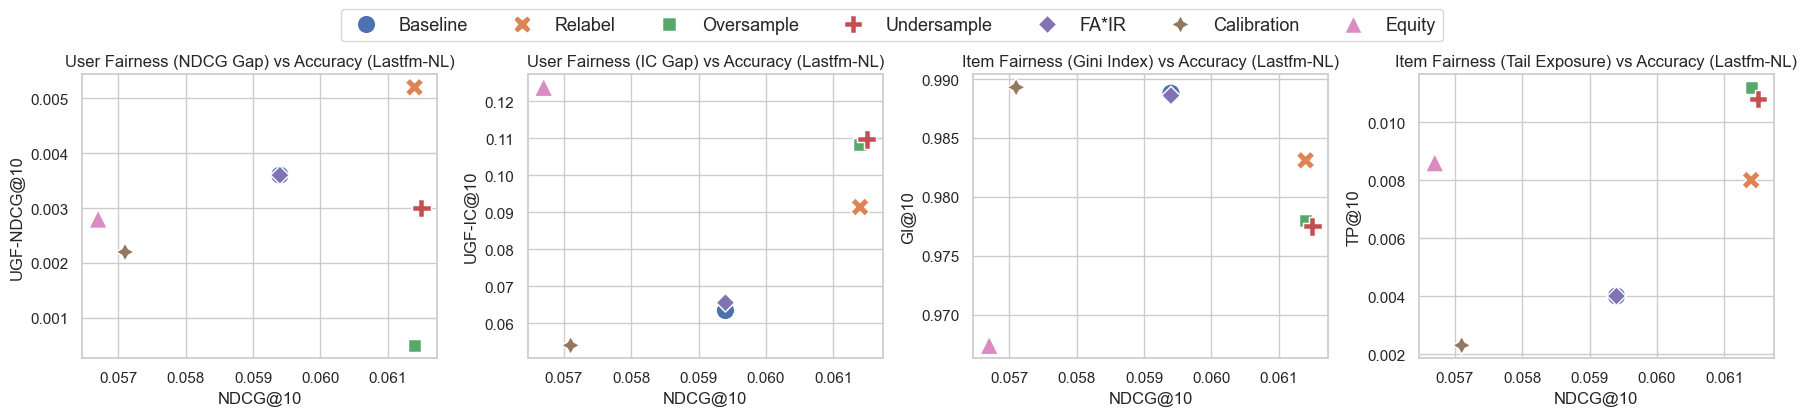

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)

# Fairness–accuracy pairs
tradeoff_pairs = [
    ("NDCG@10", "UGF-NDCG@10", "User Fairness (NDCG Gap) vs Accuracy (Lastfm-NL)"),
    ("NDCG@10", "UGF-IC@10", "User Fairness (IC Gap) vs Accuracy (Lastfm-NL)"),
    ("NDCG@10", "GI@10", "Item Fairness (Gini Index) vs Accuracy (Lastfm-NL)"),
    ("NDCG@10", "TP@10", "Item Fairness (Tail Exposure) vs Accuracy (Lastfm-NL)"),
]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes = axes.flatten()

for i, (x_col, y_col, title) in enumerate(tradeoff_pairs):
    ax = axes[i]

    sns.scatterplot(
        data=df_results,
        x=x_col, y=y_col,
        hue="Method", style="Method", s=180, ax=ax
    )

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    # Collect legend info only from the first plot
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# Add shared legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.06),
           ncol=len(labels), frameon=True, fontsize=13)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [48]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 原始方向设置
metrics_direction = {
    'NDCG@10': 'max',
    'UGF-NDCG@10': 'min',
    'UGF-IC@10': 'min',
    'GI@10': 'min',
    'TP@10': 'max',
}

# 归一化
df_norm = df_results.copy()
scaler = MinMaxScaler()

for metric, direction in metrics_direction.items():
    if direction == 'min':
        df_norm[metric] = 1 - scaler.fit_transform(df_results[[metric]])
    else:
        df_norm[metric] = scaler.fit_transform(df_results[[metric]])

# 权重方案
scenarios = {
    'Accuracy-Oriented': {'NDCG@10': 1.0},
    'User-Fairness-Oriented': {
        'NDCG@10': 0.2, 'UGF-NDCG@10': 0.4, 'UGF-IC@10': 0.2, 'GI@10': 0.1, 'TP@10': 0.1},
    'Item-Fairness-Oriented': {
        'NDCG@10': 0.2, 'UGF-NDCG@10': 0.1, 'UGF-IC@10': 0.1, 'GI@10': 0.4, 'TP@10': 0.2},
    'Balanced': {
        'NDCG@10': 0.4, 'UGF-NDCG@10': 0.2, 'UGF-IC@10': 0.1, 'GI@10': 0.2, 'TP@10': 0.1},
}

# 计算得分
score_table = {}
for name, weights in scenarios.items():
    score = sum(df_norm[k] * w for k, w in weights.items())
    score_table[name] = score

results_df = pd.DataFrame(score_table)
results_df['Method'] = df_results['Method']  # 添加方法名
results_df = results_df.set_index('Method')

# 加粗最优值
latex_df = results_df.copy()
for col in latex_df.columns:
    best_val = latex_df[col].max()
    tolerance = 1e-6
    latex_df[col] = [
        f"\\textbf{{{v:.3f}}}" if abs(v - best_val) < tolerance else f"{v:.2f}"
        for v in latex_df[col]
    ]

# 输出 LaTeX 表格
latex_output = latex_df.reset_index().to_latex(
    index=False,
    escape=False,
    column_format='l' + 'c' * (len(latex_df.columns)),
    caption="Scenario-wise Weighted Scores for Each Method",
    label="tab:scenario_scores"
)

print(latex_output)



\begin{table}
\caption{Scenario-wise Weighted Scores for Each Method}
\label{tab:scenario_scores}
\begin{tabular}{lcccc}
\toprule
Method & Accuracy-Oriented & User-Fairness-Oriented & Item-Fairness-Oriented & Balanced \\
\midrule
Baseline & 0.56 & 0.44 & 0.28 & 0.40 \\
Relabel & 0.98 & 0.38 & 0.48 & 0.56 \\
Oversample & 0.98 & \textbf{0.792} & \textbf{0.724} & \textbf{0.817} \\
Undersample & \textbf{1.000} & 0.58 & 0.67 & 0.72 \\
FA*IR & 0.56 & 0.44 & 0.28 & 0.40 \\
Calibration & 0.08 & 0.47 & 0.18 & 0.26 \\
Equity & 0.00 & 0.38 & 0.59 & 0.37 \\
\bottomrule
\end{tabular}
\end{table}



In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_metrics_row(df, metrics, ncols=None):
    sns.set(style="whitegrid", font_scale=0.9)

    n_metrics = len(metrics)
    if ncols is None:
        ncols = n_metrics
    nrows = (n_metrics + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 6 * nrows))
    axes = axes.flatten()  # Flatten in case of single row/column

    for ax, metric in zip(axes, metrics):
        sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
        ax.set_title(metric, fontsize=12)
        ax.set_xlabel("")
        ax.set_ylim(0, df[metric].max() * 1.1)  # Set y-axis limit to 120% of max value
        ax.set_ylabel("")
        ax.tick_params(axis='x', rotation=0)

        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                        (bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)

    # Hide any unused subplots
    for ax in axes[len(metrics):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax

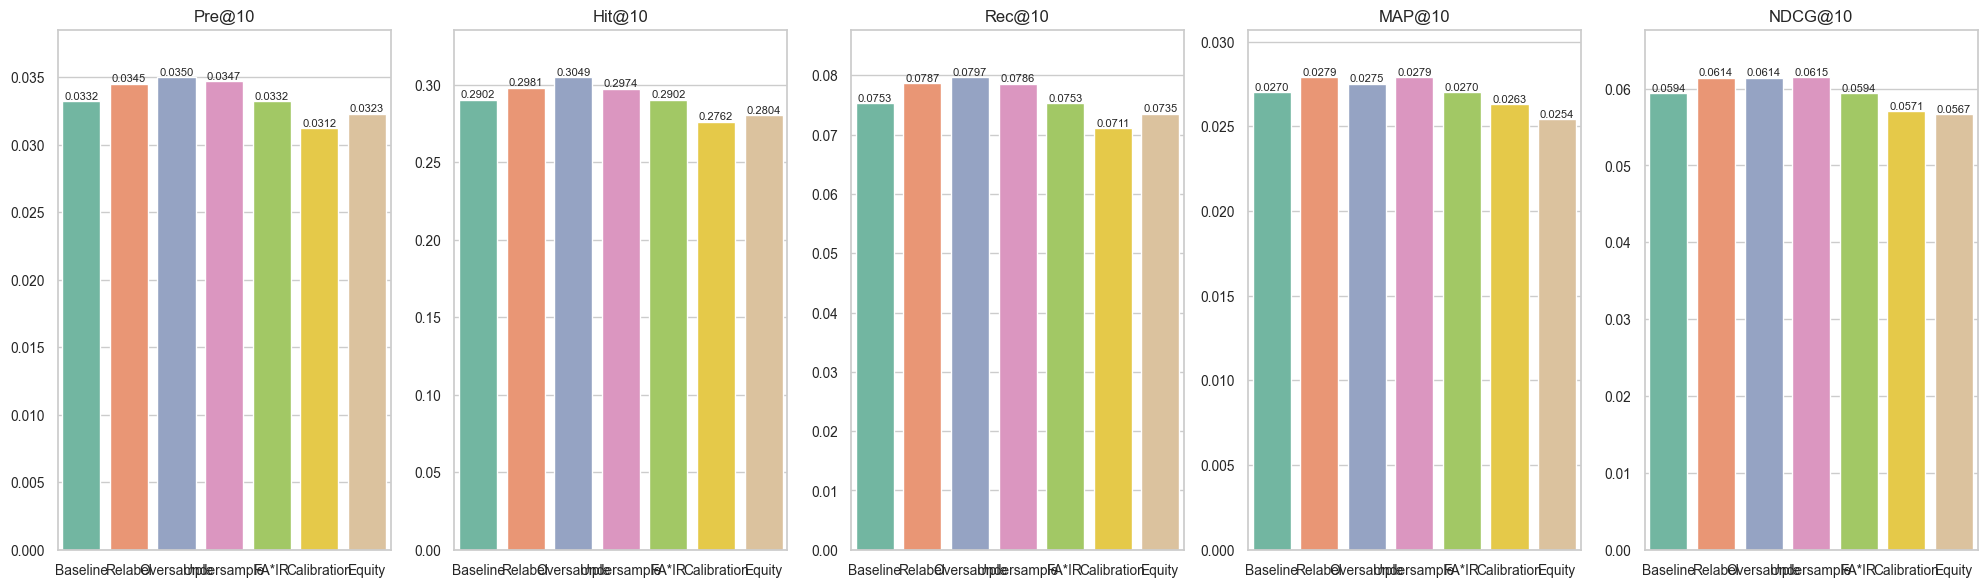

/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax

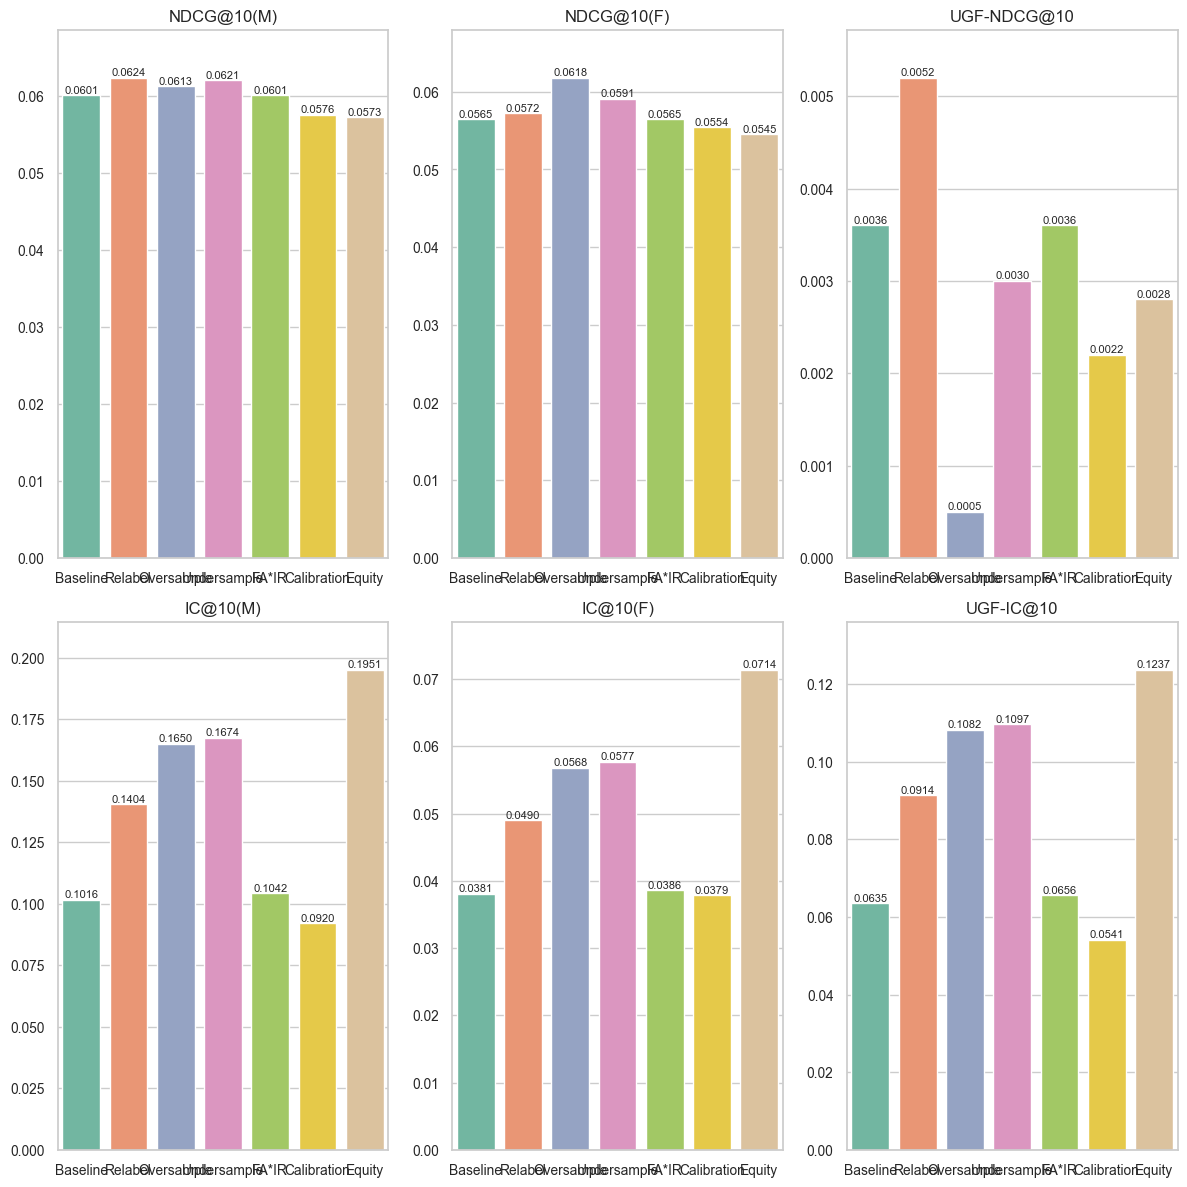

/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax)
/var/folders/p0/kj1_x6qd4_g0l4jk1pph8t840000gn/T/ipykernel_22653/3786835257.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=df, palette="Set2", ax=ax

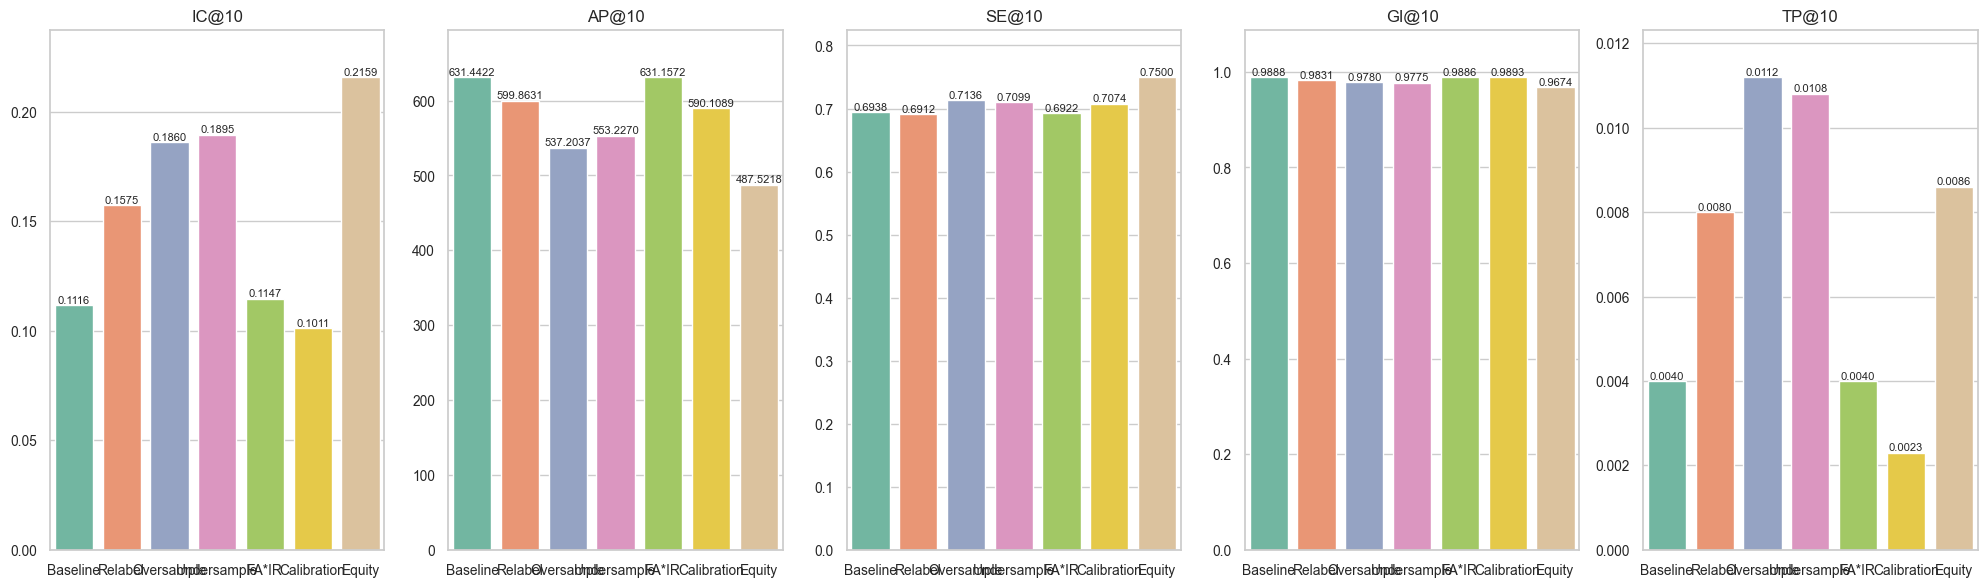

In [50]:
plot_metrics_row(df_results, acc_metrics, ncols=5)
plot_metrics_row(df_results, user_fair_metrics, ncols=3)
plot_metrics_row(df_results, item_fair_metrics, ncols=5)

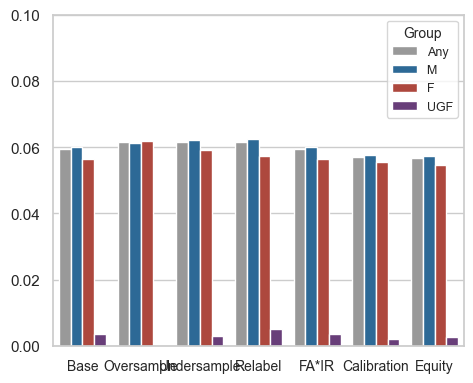

In [35]:


# === Prepare Plot Data ===
methods = df_results["Method"].tolist()
ndcg_all = df_results["NDCG@10"].tolist()
ndcg_male = df_results["NDCG@10(M)"].tolist()
ndcg_female = df_results["NDCG@10(F)"].tolist()
ndcg_differences = np.array(ndcg_male) - np.array(ndcg_female)

plot_data = []
for method, a, m, f, d in zip(methods, ndcg_all, ndcg_male, ndcg_female, ndcg_differences):
    plot_data.append({'Method': method, 'Group': 'Any', 'NDCG': a})
    plot_data.append({'Method': method, 'Group': 'M', 'NDCG': m})
    plot_data.append({'Method': method, 'Group': 'F', 'NDCG': f})
    plot_data.append({'Method': method, 'Group': 'UGF', 'NDCG': d})

df_plot = pd.DataFrame(plot_data)

# === Plotting ===
sns.set_theme(style="whitegrid")
plt.figure(figsize=(len(methods) * 0.7, 4), facecolor="white")

ax = sns.barplot(
    data=df_plot,
    x='Method', y='NDCG', hue='Group',
    palette={'Any': '#999999', 'M': '#1b6ca8', 'F': '#c0392b', 'UGF': '#6C3483'},  # Gray, Blue, Red, Purple
    width=0.8
)

# === Customize appearance ===
# Axis & labels
ax.set_ylabel("", fontsize=12)
ax.set_xlabel("")
ax.set_ylim(0, 0.1)  # Set y-axis limit to 120% of max NDCG
ax.tick_params(axis='x', labelsize=10)

# === Add legend ===
#ax.get_legend().remove()
legend = ax.legend(title="Group", fontsize=9, title_fontsize=10)
legend.set_frame_on(True)  # optional: remove box frame

# === Tight layout ===
plt.tight_layout()
plt.show()

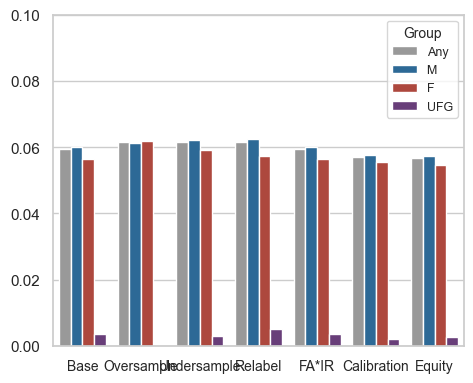

In [36]:


# === Prepare Plot Data ===
methods = df_results["Method"].tolist()
ndcg_all = df_results["NDCG@10"].tolist()
ndcg_male = df_results["NDCG@10(M)"].tolist()
ndcg_female = df_results["NDCG@10(F)"].tolist()
ndcg_differences = np.array(ndcg_male) - np.array(ndcg_female)

plot_data = []
for method, a, m, f, d in zip(methods, ndcg_all, ndcg_male, ndcg_female, ndcg_differences):
    plot_data.append({'Method': method, 'Group': 'Any', 'NDCG': a})
    plot_data.append({'Method': method, 'Group': 'M', 'NDCG': m})
    plot_data.append({'Method': method, 'Group': 'F', 'NDCG': f})
    plot_data.append({'Method': method, 'Group': 'UFG', 'NDCG': d})

df_plot = pd.DataFrame(plot_data)

# === Plotting ===
sns.set_theme(style="whitegrid")
plt.figure(figsize=(len(methods) * 0.7, 4), facecolor="white")

ax = sns.barplot(
    data=df_plot,
    x='Method', y='NDCG', hue='Group',
    palette={'Any': '#999999', 'M': '#1b6ca8', 'F': '#c0392b', 'UFG': '#6C3483'},  # Gray, Blue, Red, Purple
    width=0.8
)

# === Customize appearance ===
# Axis & labels
ax.set_ylabel("", fontsize=12)
ax.set_xlabel("")
ax.set_ylim(0, 0.1)  # Set y-axis limit to 120% of max NDCG
ax.tick_params(axis='x', labelsize=10)

# === Add legend ===
#ax.get_legend().remove()
legend = ax.legend(title="Group", fontsize=9, title_fontsize=10)
legend.set_frame_on(True)  # optional: remove box frame

# === Tight layout ===
plt.tight_layout()
plt.show()